# 🧭 Projet - Problème du Voyageur de Commerce (TSP)

---

Ce projet explore des heuristiques pour résoudre le **Problème du Voyageur de Commerce (Travelling Salesman Problem)**.
Nous allons implémenter et comparer différentes approches pour trouver un circuit de coût minimal visitant chaque ville une seule fois.

---

👨‍💻 Myriam HADDOUK & Myriam SCHULMANN
🎓 Projet Mathématiques-informatique
📅 Juin 2025

**Imports**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math

### **City Generation**

In [2]:
def generate_cities(n: int, seed: int = None) -> np.ndarray:
    """
    Generate a set of cities with random (x, y) coordinates in a 1000x1000 grid.

    Parameters:
    - n (int): Number of cities to generate.
    - seed (int, optional): Random seed for reproducibility.

    Returns:
    - np.ndarray: Array of shape (n, 2) with x and y coordinates of each city.
    """
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)

    return np.random.randint(0, 1000, size=(n, 2))

In [3]:
cities = generate_cities(20, seed=42)
print(cities)

[[102 435]
 [860 270]
 [106  71]
 [700  20]
 [614 121]
 [466 214]
 [330 458]
 [ 87 372]
 [ 99 871]
 [663 130]
 [661 308]
 [769 343]
 [491 413]
 [805 385]
 [191 955]
 [276 160]
 [459 313]
 [ 21 252]
 [747 856]
 [560 474]]


**Distance Matrix**

In [4]:
def compute_distance_matrix(cities: np.ndarray) -> np.ndarray:
    """
    Compute the pairwise Euclidean distance matrix between all cities.

    Parameters:
    - cities (np.ndarray): Array of shape (n, 2) with x and y coordinates.

    Returns:
    - np.ndarray: Array of shape (n, n) with distances between each pair of cities.
    """
    n = cities.shape[0]
    matrix = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            if i != j:
                dx = cities[i][0] - cities[j][0]
                dy = cities[i][1] - cities[j][1]
                matrix[i][j] = math.hypot(dx, dy)

    return matrix

In [5]:
distance_matrix = compute_distance_matrix(cities)
print(distance_matrix)

[[   0.          775.75060425  364.02197736  727.89353617  600.61635009
   425.83682321  229.15715132   64.76109943  436.01032098  638.54991974
   573.24514826  673.31493374  389.62161131  704.77585089  527.56137084
   325.42433836  377.27046002  200.12496096  770.23762567  459.65748117]
 [ 775.75060425    0.          779.81856864  296.81644159  287.60563277
   397.95979696  562.35575928  779.70058356  969.70201609  241.67953989
   202.59565642  116.66190466  395.73981351  127.47548784  957.48942553
   594.26929922  403.2988966   839.19306479  596.7956099   362.78919499]
 [ 364.02197736  779.81856864    0.          596.18537386  510.45469926
   387.36158818  447.1520994   301.59907162  800.03062441  560.1160594
   603.48487968  716.62612288  514.96504736  766.28780494  888.07713629
   191.88798816  427.98714934  199.96499694 1013.46238213  607.06259974]
 [ 727.89353617  296.81644159  596.18537386    0.          132.65368446
   303.96052375  573.36201479  706.87551945 1041.8262811   116

### **Heuristics**

**Nearest Neighbor**

In [6]:
def nearest_neighbor_tour(distance_matrix: np.ndarray, start: int = 0) -> list:
    """
    Construct a TSP tour using the nearest neighbor heuristic.

    Parameters:
    - distance_matrix (np.ndarray): Pairwise distance matrix.
    - start (int): Index of the starting city.

    Returns:
    - list: Ordered list of city indices representing the tour.
    """
    n = distance_matrix.shape[0]
    visited = [False] * n
    tour = [start]
    visited[start] = True

    current = start
    for _ in range(n - 1):
        next_city = min(
            (i for i in range(n) if not visited[i]),
            key=lambda i: distance_matrix[current][i]
        )
        tour.append(next_city)
        visited[next_city] = True
        current = next_city

    return tour

In [7]:
tour = nearest_neighbor_tour(distance_matrix, start=0)
print(tour)

[0, 7, 17, 2, 15, 5, 16, 12, 19, 10, 11, 13, 1, 9, 4, 3, 6, 8, 14, 18]


**Insertion**

In [8]:
def insertion_tour(distance_matrix: np.ndarray, start: int = 0) -> list:
    """
    Build a TSP tour using the insertion heuristic.

    Parameters:
    - distance_matrix (np.ndarray): Pairwise distance matrix.
    - start (int): Index of the starting city.

    Returns:
    - list: Ordered list of city indices representing the tour.
    """
    n = distance_matrix.shape[0]
    unvisited = set(range(n))
    tour = [start]
    unvisited.remove(start)

    nearest = min(unvisited, key=lambda i: distance_matrix[start][i])
    tour.append(nearest)
    unvisited.remove(nearest)

    tour.append(start)

    while unvisited:
        best_city = None
        best_position = None
        min_increase = float('inf')

        for city in unvisited:
            for i in range(1, len(tour)):
                prev_city = tour[i - 1]
                next_city = tour[i]
                increase = (
                    distance_matrix[prev_city][city] +
                    distance_matrix[city][next_city] -
                    distance_matrix[prev_city][next_city]
                )
                if increase < min_increase:
                    min_increase = increase
                    best_city = city
                    best_position = i

        tour.insert(best_position, best_city)
        unvisited.remove(best_city)

    return tour[:-1]

In [9]:
tour = insertion_tour(distance_matrix, start=0)
print(tour)

[0, 6, 19, 12, 8, 14, 18, 13, 1, 11, 10, 9, 3, 4, 16, 5, 15, 2, 17, 7]


**Two-Opt**

In [10]:
def two_opt(tour: list, distance_matrix: np.ndarray) -> list:
    """
    Improve a given TSP tour using the two-opt heuristic.

    Parameters:
    - tour (list): Initial tour as a list of city indices.
    - distance_matrix (np.ndarray): Pairwise distance matrix.

    Returns:
    - list: Locally optimized tour using two-opt.
    """
    improved = True
    n = len(tour)
    best = tour[:]

    def tour_length(t):
        return sum(distance_matrix[t[i]][t[(i + 1) % n]] for i in range(n))

    while improved:
        improved = False
        for i in range(1, n - 2):
            for j in range(i + 1, n):
                if j - i == 1:
                    continue
                new_tour = best[:i] + best[i:j][::-1] + best[j:]
                if tour_length(new_tour) < tour_length(best):
                    best = new_tour
                    improved = True
                    break
            if improved:
                break

    return best

In [11]:
initial_tour = nearest_neighbor_tour(distance_matrix, start=0)
print(initial_tour)
optimized_tour = two_opt(initial_tour, distance_matrix)
print(optimized_tour)

[0, 7, 17, 2, 15, 5, 16, 12, 19, 10, 11, 13, 1, 9, 4, 3, 6, 8, 14, 18]
[0, 7, 17, 2, 15, 5, 4, 9, 3, 1, 13, 11, 10, 19, 12, 16, 6, 8, 14, 18]


In [12]:
initial_tour = insertion_tour(distance_matrix, start=0)
print(initial_tour)
optimized_tour = two_opt(initial_tour, distance_matrix)
print(optimized_tour)

[0, 6, 19, 12, 8, 14, 18, 13, 1, 11, 10, 9, 3, 4, 16, 5, 15, 2, 17, 7]
[0, 6, 12, 19, 8, 14, 18, 13, 1, 11, 10, 9, 3, 4, 5, 16, 15, 2, 17, 7]


**Simulated Annealing**

In [13]:
def simulated_annealing(
    initial_tour: list,
    distance_matrix: np.ndarray,
    initial_temp: float = 1000,
    final_temp: float = 1,
    alpha: float = 0.995,
    max_iter: int = 10000
) -> list:
    """
    Apply simulated annealing to improve a TSP tour.

    Parameters:
    - initial_tour (list): Starting tour.
    - distance_matrix (np.ndarray): Pairwise distance matrix.
    - initial_temp (float): Initial temperature.
    - final_temp (float): Final temperature to stop.
    - alpha (float): Cooling rate.
    - max_iter (int): Maximum number of iterations.

    Returns:
    - list: Final optimized tour.
    """
    def tour_cost(tour):
        return sum(distance_matrix[tour[i]][tour[(i + 1) % len(tour)]] for i in range(len(tour)))

    def swap_two(tour):
        i, j = sorted(random.sample(range(len(tour)), 2))
        return tour[:i] + tour[i:j+1][::-1] + tour[j+1:]

    current = initial_tour[:]
    current_cost = tour_cost(current)
    best = current[:]
    best_cost = current_cost
    temp = initial_temp

    for _ in range(max_iter):
        if temp <= final_temp:
            break

        candidate = swap_two(current)
        candidate_cost = tour_cost(candidate)
        delta = candidate_cost - current_cost

        if delta < 0 or random.random() < math.exp(-delta / temp):
            current = candidate
            current_cost = candidate_cost
            if candidate_cost < best_cost:
                best = candidate
                best_cost = candidate_cost

        temp *= alpha

    return best

In [14]:
start_tour = nearest_neighbor_tour(distance_matrix, start=0)
print(start_tour)
final_tour = simulated_annealing(start_tour, distance_matrix)
print(final_tour)

[0, 7, 17, 2, 15, 5, 16, 12, 19, 10, 11, 13, 1, 9, 4, 3, 6, 8, 14, 18]
[13, 11, 10, 16, 6, 12, 19, 18, 14, 8, 0, 7, 17, 2, 15, 5, 4, 9, 3, 1]


In [15]:
start_tour = insertion_tour(distance_matrix, start=0)
print(start_tour)
final_tour = simulated_annealing(start_tour, distance_matrix)
print(final_tour)

[0, 6, 19, 12, 8, 14, 18, 13, 1, 11, 10, 9, 3, 4, 16, 5, 15, 2, 17, 7]
[5, 4, 3, 9, 10, 11, 1, 13, 18, 14, 8, 0, 7, 17, 2, 15, 6, 19, 12, 16]


### **Visualization**

**Single Tour**

In [16]:
def plot_tour(
    cities: np.ndarray,
    tour: list,
    title: str = "TSP Tour",
    show_lengths: bool = False
):
    """
    Display a single TSP tour with optional edge lengths.

    Parameters:
    - cities (np.ndarray): City coordinates.
    - tour (list): Ordered list of city indices forming the tour.
    - title (str): Plot title.
    - show_lengths (bool): If True, display segment distances on the plot.
    """
    x = [cities[i][0] for i in tour] + [cities[tour[0]][0]]
    y = [cities[i][1] for i in tour] + [cities[tour[0]][1]]

    plt.figure(figsize=(8, 6))
    plt.plot(x, y, marker='o')
    plt.scatter(cities[:, 0], cities[:, 1], s=200, color='red', zorder=4)

    for idx, (xi, yi) in enumerate(cities):
        plt.text(xi, yi, str(idx), fontsize=8, weight='bold', ha='center', va='center', color='black', zorder=5)

    if show_lengths:
        for i in range(len(tour)):
            a, b = tour[i], tour[(i + 1) % len(tour)]
            xa, ya = cities[a]
            xb, yb = cities[b]
            mid_x, mid_y = (xa + xb) / 2, (ya + yb) / 2
            dist = math.hypot(xa - xb, ya - yb)
            plt.text(
                mid_x, mid_y, f"{dist:.1f}", fontsize=7, color='black',
                bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.2')
            )

    plt.title(title)
    plt.axis("equal")
    plt.grid(True)
    plt.show()

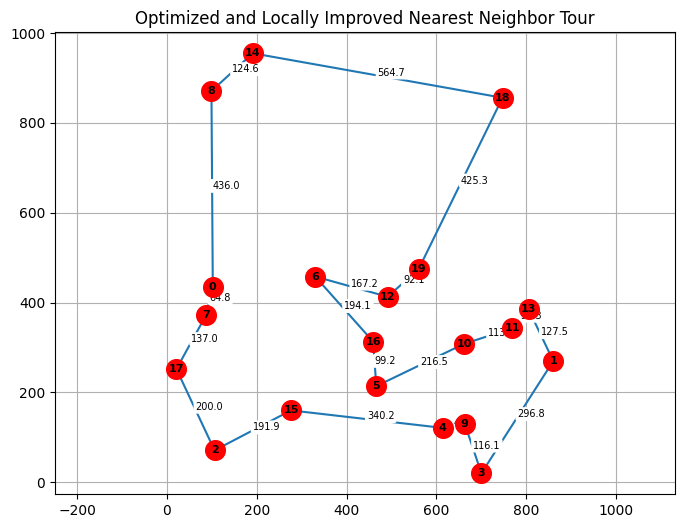

In [17]:
tour = two_opt(simulated_annealing(nearest_neighbor_tour(distance_matrix, start=0), distance_matrix), distance_matrix)
plot_tour(cities, tour, title="Optimized and Locally Improved Nearest Neighbor Tour", show_lengths=True)

**Multiple Tours**

In [18]:
def plot_multiple_tours(
    cities: np.ndarray,
    tours: list,
    labels: list = None,
    title: str = "Multiple TSP Tours"
):
    """
    Display multiple TSP tours on the same city map for comparison.

    Parameters:
    - cities (np.ndarray): City coordinates.
    - tours (list of list): List of tours to plot.
    - labels (list of str): Optional labels for the legend.
    - title (str): Plot title.
    """
    if len(tours) > 3:
        print("⚠️ Warning: plotting more than 3 tours may reduce readability.")

    plt.figure(figsize=(8, 6))

    colors = [
        'blue', 'orange', 'green', 'purple', 'brown',
        'pink', 'gray', 'olive', 'cyan', 'red'
    ]
    linestyles = ['-', '--', ':', '-.']

    for idx, tour in enumerate(tours):
        x = [cities[i][0] for i in tour] + [cities[tour[0]][0]]
        y = [cities[i][1] for i in tour] + [cities[tour[0]][1]]
        color = colors[idx % len(colors)]
        style = linestyles[idx % len(linestyles)]
        label = labels[idx] if labels and idx < len(labels) else f"Tour {idx+1}"
        plt.plot(x, y, linestyle=style, color=color, marker='o', label=label)

    plt.scatter(cities[:, 0], cities[:, 1], color='black', zorder=5)
    for idx, (xi, yi) in enumerate(cities):
        plt.text(xi + 5, yi + 5, str(idx), fontsize=8)

    plt.title(title)
    plt.axis("equal")
    plt.grid(True)
    plt.legend()
    plt.show()

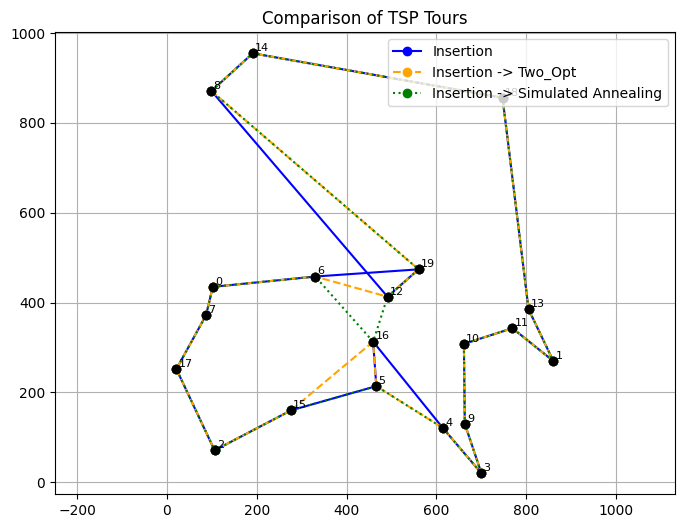

In [19]:
tour = insertion_tour(distance_matrix)
tours = [
    tour,
    two_opt(tour, distance_matrix),
    simulated_annealing(tour, distance_matrix)
]

plot_multiple_tours(
    cities,
    tours,
    labels=["Insertion", "Insertion -> Two_Opt", "Insertion -> Simulated Annealing"],
    title="Comparison of TSP Tours"
)

### **Comparisons**

**Execution Time**

In [20]:
import time

def measure_time(func, *args, **kwargs):
    """
    Measure the execution time of a function call.

    Parameters:
    - func: Function to execute.
    - *args, **kwargs: Arguments to pass to the function.

    Returns:
    - tuple: (result of the function, execution time in seconds)
    """
    start = time.time()
    result = func(*args, **kwargs)
    end = time.time()
    elapsed = end - start
    return result, elapsed

In [21]:
tour, exec_time = measure_time(nearest_neighbor_tour, distance_matrix)
print(f"Function: nearest_neighbor_tour\n"
      f"Execution time: {exec_time:.6f} seconds")

Function: nearest_neighbor_tour
Execution time: 0.000096 seconds


**Tour Cost**

In [22]:
def compute_tour_cost(tour: list, distance_matrix: np.ndarray) -> float:
    """
    Compute the total distance of a TSP tour.

    Parameters:
    - tour (list): Ordered list of city indices forming the tour.
    - distance_matrix (np.ndarray): Pairwise distance matrix.

    Returns:
    - float: Total cost of the tour.
    """
    return sum(
        distance_matrix[tour[i]][tour[(i + 1) % len(tour)]]
        for i in range(len(tour))
    )

In [23]:
tour = two_opt(simulated_annealing(insertion_tour(distance_matrix), distance_matrix), distance_matrix)
cost = compute_tour_cost(tour, distance_matrix)
print(f"Tour cost: {cost:.2f}")

Tour cost: 3965.38


**Comparison DataFrame**

In [24]:
import pandas as pd

default_sizes = [10, 25, 50, 75]
def create_comparison_df(sizes : list = default_sizes, sample_size : int = 10) -> pd.DataFrame:
    """
    Create tour cost and time comparison DataFrame for different combinations of heuristics.

    Parameters:
    - sizes (list): Optional list of sizes of city datasets.
    - sample_size (int): Number of different city datasets to generate.

    Returns:
    - pd.DataFrame: Comparison DataFrame.
    """
    results = []
    for size in sizes:
        for run in range(sample_size):
            cities = generate_cities(size, seed=run)
            distance_matrix = compute_distance_matrix(cities)

            for heuristic_name, heuristic_function in [
                ('nearest_neighbor', nearest_neighbor_tour),
                ('insertion', insertion_tour),
            ]:
                base_tour, first_duration = measure_time(heuristic_function, distance_matrix, start=0)

                for use_two_opt in [False, True]:
                    for use_simulated_annealing in [False, True]:
                        tour = base_tour[:]
                        duration = first_duration

                        if use_two_opt:
                            tour, added_duration = measure_time(two_opt, tour, distance_matrix)
                            duration += added_duration
                        if use_simulated_annealing:
                            tour, added_duration = measure_time(simulated_annealing, tour, distance_matrix)
                            duration += added_duration

                        cost = compute_tour_cost(tour, distance_matrix)

                        results.append({
                            "size": size,
                            "run_id": run,
                            "heuristic": heuristic_name,
                            "two_opt": use_two_opt,
                            "simulated_annealing": use_simulated_annealing,
                            "cost": cost,
                            "time": duration,
                        })

    return pd.DataFrame(results)

In [25]:
df = create_comparison_df()
df

,size,run_id,heuristic,two_opt,simulated_annealing,cost,time
0,10,0,nearest_neighbor,False,False,2848.073287,0.000040
1,10,0,nearest_neighbor,False,True,2513.217277,0.010521
2,10,0,nearest_neighbor,True,False,2700.607901,0.000404
3,10,0,nearest_neighbor,True,True,2513.217277,0.010604
4,10,0,insertion,False,False,2681.899719,0.000137
...,...,...,...,...,...,...,...
315,75,9,nearest_neighbor,True,True,7584.664901,0.635509
316,75,9,insertion,False,False,8000.229942,0.035352
317,75,9,insertion,False,True,8000.229942,0.061676
318,75,9,insertion,True,False,7503.845405,0.436835
